# Introduction
Author: Reuben Jooste (u21457060)

In this project we look at how we can use Data Mining techniques such as Sentiment Analysis and Topic Modelling, to extract insights from Amazon customers regarding the Software products and services offered. Analysing the reviews can reveal sentiment trends, trending topics/products, and what customers like and dislike, allowing the business to then make changes to their services to better fit customer needs which will lead to an
increase in customer satisfaction and potentially increased revenue for the company.

### Data:
We will use the *Software* customer reviews dataset created by Amazon. The dataset can be found at [this](https://amazon-reviews-2023.github.io) link and then scrolling down and selecting the Software dataset.

This dataset contains 4.8M records with the following attributes:

| Field | Type | Explanation |
| ----- | ---- | ----------- |
| rating | float | Rating of the product (from 1.0 to 5.0). |
| title | str | Title of the user review. |
| text | str | Text body of the user review. |
| images | list | Images that users post after they have received the product. Each image has different sizes (small, medium, large), represented by | the small_image_url, medium_image_url, and large_image_url respectively. |
| asin | str | ID of the product. |
| parent_asin | str | Parent ID of the product. Note: Products with different colors, styles, sizes usually belong to the same parent ID. The “asin” in previous Amazon datasets is actually parent ID. Please use parent ID to find product meta. |
| user_id | str | ID of the reviewer |
| timestamp | int | Time of the review (unix time) |
| verified_purchase | bool | User purchase verification |
| helpful_vote | int | Helpful votes of the review |

Furthermore, we will use the corresponding META dataset to help clarify what the categories of the products are based on the *parent_asin* attribute.

### Approach:
**Sentiment Analysis:**

We will first preprocess the data to remove any stop words, as well as apply tokenisation and lemmatisation techniques. Using a pre-trained model such as TextBlob, we will classify the processed subset of data as positive, negative, or neutral and label the data. Based on the labelled data we will then analyse the sentiment trends by product ratings, time, and purchase verification. 

**Topic Modelling:**

We will apply similar preprocessing techniques as the sentiment analysis approach, with an emphasis on text cleaning. This will remove any special characters and irrelevant content. Using the Latent Dirichlet Allocation (LDA), we will extract the key topics from all the reviews. Based on the extracted topics, we can when examine the distribution across different product ratings as well as track how certain topics got more popular or less popular over time.

### Evaluation:
**Sentiment Analysis:**
- We will compare the *sentiment polarity* with the *review rating* to measure whether the sentiment predictions were accurate or not. 
- We will use time-series plots to measure if a product’s sentiment improved over time. 

**Topic Modelling:**
- We will use *coherence scores* to evaluate the topics generated by the LDA algorithm. 
- Distribution plots will also be used to verify whether meaningful patterns emerge e.g. if praising comments are concentrated in highly-rated reviews. 

*Baseline:* We will assume that reviews with low ratings (below 3) correspond to negative sentiment and vice versa.

# Libraries
This section contains all required libraries and packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from textblob import TextBlob
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Ensure the required NLTK resources downloaded
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from scipy import stats

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preprocessing
In this section we preprocess the data to ensure it is clean of any erroneous data (e.g. missing values, duplicates, etc.). We will also explore the dataset using descriptive statistics and other methods to better understand the content and structure of the dataset.

In [2]:
# reading the JSON data using json.load()
file_path = '/kaggle/input/cos781-amazon-software-reviews/Software.jsonl'
data = pd.read_json(file_path, lines=True)
data.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1,malware,mcaffee IS malware,[],B07BFS3G7P,B0BQSK9QCF,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2019-07-03 19:37:12.076,0,False
1,5,Lots of Fun,I love playing tapped out because it is fun to...,[],B00CTQ6SIG,B00CTQ6SIG,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-02-16 20:58:56.000,0,True
2,5,Light Up The Dark,I love this flashlight app! It really illumin...,[],B0066WJLU6,B0066WJLU6,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2013-03-04 12:14:27.000,0,True
3,4,Fun game,One of my favorite games,[],B00KCYMAWK,B00KCYMAWK,AH6CATODIVPVUOJEWHRSRCSKAOHA,2019-06-20 20:10:28.662,0,True
4,4,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,[],B00P1RK566,B00P1RK566,AEINY4XOINMMJCK5GZ3M6MMHBN6A,2014-12-11 00:19:56.000,0,True


In [3]:
# load meta data
meta_data = pd.read_json('/kaggle/input/cos781-amazon-software-reviews/meta_Software.jsonl', lines=True)
meta_data.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Appstore for Android,Accupressure Guide,3.6,NaN,[All the pressing point has been explained wit...,[Acupressure technique is very ancient and ver...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",mAppsguru,[],"{'Release Date': '2015', 'Date first listed on...",B00VRPSGEO,NaN,NaN,NaN
1,Appstore for Android,Ankylosaurus Fights Back - Smithsonian's Prehi...,4.0,NaN,[ENCOURAGE literacy skills with highlighted na...,[Join Ankylosaurus in this interactive book ap...,2.99,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]","Oceanhouse Media, Inc",[],"{'Release Date': '2014', 'Date first listed on...",B00NWQXXHQ,NaN,NaN,NaN
2,Appstore for Android,Mahjong 2015,3.1,NaN,[Mahjong 2015 is a free solitaire matching gam...,[Mahjong 2015 is a free solitaire matching gam...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",sophiathach,[],"{'Release Date': '2014', 'Date first listed on...",B00RFKP6AC,NaN,NaN,NaN
3,Appstore for Android,Jewels Brick Breakout,4.2,NaN,"[Game Features:, - Intuitive touch controls wi...",[Jewels Brick Breakout is a glowing jewels bri...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",Bad Chicken,[],"{'Release Date': '2015', 'Date first listed on...",B00SP2QU0E,NaN,NaN,NaN
4,Appstore for Android,Traffic Police: Off-Road Cub,3.3,NaN,"[In this game you will find:, - Killer police ...",[Become the best road police officer in Cube C...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",Dast 2 For Metro,[],"{'Release Date': '2016', 'Date first listed on...",B01DZIT64O,NaN,NaN,NaN


### Feature Engineering
We now have both the reviews and their meta data but we do not know the category of the products in our reviews dataset. Therefore, we use the parent_asin attribute in each dataset to create a new product category attribute in our reviews dataset.

In [4]:
merged_df = pd.merge(data, meta_data, on='parent_asin', how='left')
merged_df.head()

,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,description,price,images_y,videos,store,categories,details,bought_together,subtitle,author
0,1,malware,mcaffee IS malware,[],B07BFS3G7P,B0BQSK9QCF,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2019-07-03 19:37:12.076,0,False,...,[All-in-one online protection for your persona...,34.99,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'McAfee REAL Support', 'url': 'http...",McAfee,"[Software, Antivirus & Security, Internet Secu...",{'Product Dimensions': '7.5 x 5.5 x 0.5 inches...,NaN,NaN,NaN
1,5,Lots of Fun,I love playing tapped out because it is fun to...,[],B00CTQ6SIG,B00CTQ6SIG,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-02-16 20:58:56.000,0,True,...,[THIS GAME IS LIFE-RUININGLY FUN!From the writ...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",Electronic Arts,[],"{'Release Date': '2013', 'Date first listed on...",NaN,NaN,NaN
2,5,Light Up The Dark,I love this flashlight app! It really illumin...,[],B0066WJLU6,B0066WJLU6,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2013-03-04 12:14:27.000,0,True,...,"[There are many flashlight apps, so why get th...",0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",smallte.ch,[],"{'Release Date': '2011', 'Date first listed on...",NaN,NaN,NaN
3,4,Fun game,One of my favorite games,[],B00KCYMAWK,B00KCYMAWK,AH6CATODIVPVUOJEWHRSRCSKAOHA,2019-06-20 20:10:28.662,0,True,...,[Experience the best WMS & Bally slot games wi...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': 'https://images-na.ssl-i...",SG Interactive,[],"{'Release Date': '2014', 'Date first listed on...",NaN,NaN,NaN
4,4,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,[],B00P1RK566,B00P1RK566,AEINY4XOINMMJCK5GZ3M6MMHBN6A,2014-12-11 00:19:56.000,0,True,...,[SkyBalance by Nik Wallenda puts the legendary...,0.99,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",Tapinator,[],"{'Release Date': '2014', 'Date first listed on...",NaN,NaN,NaN


In [6]:
# we drop the following features since we do not need it for our analysis
merged_df.drop(['images_x', 'images_y', 'user_id', 'helpful_vote', 'average_rating', 'rating_number', 'features', 'description', 'price', 'videos', 'store', 'categories', 'details', 'bought_together', 'subtitle', 'author'], inplace=True, axis=1)
merged_df.head(2)

,rating,title_x,text,asin,parent_asin,timestamp,verified_purchase,main_category,title_y
0,1,malware,mcaffee IS malware,B07BFS3G7P,B0BQSK9QCF,2019-07-03 19:37:12.076,False,Software,"McAfee Total Protection 2022 [Old Version], 10..."
1,5,Lots of Fun,I love playing tapped out because it is fun to...,B00CTQ6SIG,B00CTQ6SIG,2015-02-16 20:58:56.000,True,Appstore for Android,The Simpsons: Tapped Out


In [7]:
# reorder columns
merged_df = merged_df[['main_category', 'title_x', 'title_y', 'text', 'asin', 'parent_asin', 'verified_purchase', 'rating', 'timestamp']]
merged_df.head(2)

,main_category,title_x,title_y,text,asin,parent_asin,verified_purchase,rating,timestamp
0,Software,malware,"McAfee Total Protection 2022 [Old Version], 10...",mcaffee IS malware,B07BFS3G7P,B0BQSK9QCF,False,1,2019-07-03 19:37:12.076
1,Appstore for Android,Lots of Fun,The Simpsons: Tapped Out,I love playing tapped out because it is fun to...,B00CTQ6SIG,B00CTQ6SIG,True,5,2015-02-16 20:58:56.000


In [8]:
merged_df.shape

(4880181, 9)

In [9]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880181 entries, 0 to 4880180
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   main_category      object        
 1   title_x            object        
 2   title_y            object        
 3   text               object        
 4   asin               object        
 5   parent_asin        object        
 6   verified_purchase  bool          
 7   rating             int64         
 8   timestamp          datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 302.5+ MB


In [10]:
merged_df.describe()

,rating,timestamp
count,4.880181e+06,4880181
mean,3.935087e+00,2016-08-11 20:56:15.320964864
min,1.000000e+00,1999-03-15 04:02:39
25%,3.000000e+00,2014-09-03 01:27:03
50%,5.000000e+00,2016-03-19 18:49:49
75%,5.000000e+00,2018-08-15 19:51:14.231000064
max,5.000000e+00,2023-09-11 02:13:11.515000
std,1.451875e+00,NaN


In [11]:
merged_df.isnull().sum()

main_category        6245
title_x                 0
title_y                 0
text                    0
asin                    0
parent_asin             0
verified_purchase       0
rating                  0
timestamp               0
dtype: int64

In [12]:
# drop categories with no ID
merged_df.dropna(inplace=True)
merged_df.isnull().sum()

/tmp/ipykernel_30/279203907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.dropna(inplace=True)


main_category        0
title_x              0
title_y              0
text                 0
asin                 0
parent_asin          0
verified_purchase    0
rating               0
timestamp            0
dtype: int64

In [13]:
# check duplicates
df = merged_df.copy()
# check duplicate rows
column_duplicates = df.duplicated().sum()
print(f'Total duplicate rows: {column_duplicates}')

Total duplicate rows: 51027


In [14]:
# drop duplicate rows
data_clean = merged_df.drop_duplicates()

In [15]:
# unique number of products
data_clean['parent_asin'].unique().shape

(87477,)

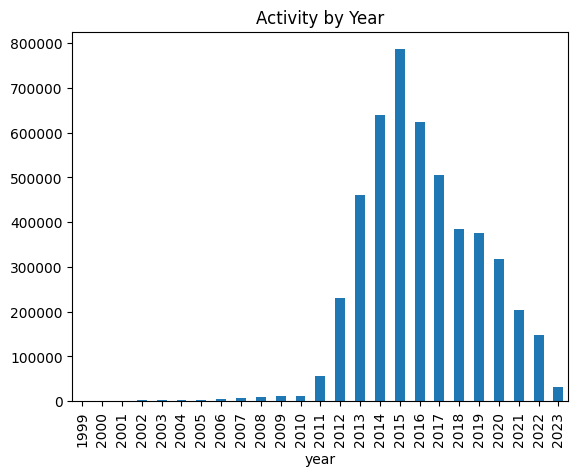

In [16]:
# analyse activity based on specific time (e.g. year, month, etc.)
def plot_timestamp(df, time_period):
    if time_period == 'year':
        df['year'].value_counts().sort_index().plot(kind='bar', title='Activity by Year')
    else:
        raise Exception('Invalid time period')

# Convert 'timestamp' from Unix time to datetime
df = data_clean.copy()
# Convert 'timestamp' from Unix time to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Extract the year from the 'datetime' column
df['year'] = df['datetime'].dt.year

# Extract the year from the 'datetime' column
df['year'] = df['datetime'].dt.year
plot_timestamp(df, 'year')

From the plot above we can see that there was a significant increase in product reviews from 2011 to 2015 and then decreased for the subsequent years. The raises questions such as *How did the sentiment change over the years?* or *What product were developed between these years that caused such a big difference in activity in terms of reviews?*

We will focus on the review between this 10 year (2012 - 2021) period.

### Filter data

In [17]:
# top 10 products
merged_df['title_y'].value_counts()[:10]

title_y
Candy Crush Saga           50914
Amazon Prime Video         46940
Minecraft                  44335
Solitaire                  43212
Netflix                    41709
YouTube                    39727
Facebook                   30212
Pluto TV - It’s Free TV    27666
Downloader                 27101
Crossy Road                26870
Name: count, dtype: int64

In [18]:
top10_products = merged_df['title_y'].value_counts().keys()[:10]

# filter the dataset
filtered_top10_df = merged_df[merged_df['title_y'].isin(top10_products)]
filtered_top10_df.shape

(378686, 9)

In [19]:
df = filtered_top10_df.copy()
# Convert 'timestamp' from Unix time to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Extract the year from the 'datetime' column
df['year'] = df['datetime'].dt.year

# Filter dataset
filtered_data = df[(df['year'] >= 2012) & (df['year'] < 2022)]
filtered_data['year'].value_counts()

year
2015    68381
2016    54266
2014    49434
2017    47421
2019    39448
2020    29403
2013    29015
2018    25736
2021    14926
2012     9778
Name: count, dtype: int64

In [32]:
# # analyse the distribution of the numerical attributes
# def plot_distribution(df, info):
#     if info in ['rating', 'verified_purchase']:
#         # Calculate the distribution of the specified column
#         group_distribution = df[info].value_counts().sort_index()

#         # Convert the index to a DataFrame and extract the start of the range for sorting
#         group_distribution = group_distribution.reset_index()
#         group_distribution.columns = [info, 'count']

#         # visualize the distribution
#         fig, ax = plt.subplots(figsize=(12, 6))  # Create a figure and axes with desired size
#         bars = group_distribution.plot(kind='bar', ax=ax, legend=False)  # Plot the data on the created axes

#         # Add labels on top of the bars
#         ax.bar_label(bars.containers[0], label_type='edge')

#         plt.xlabel(info)
#         plt.ylabel('Frequency')
#         plt.title(f'Distribution of {info}')
#         plt.show()
    
#         return group_distribution
#     elif info == 'text_length_vs_rating':
#         # Do longer reviews give higher or lower ratings
#         df['text_length'] = df['text'].apply(len)
#         return df.plot.scatter('text_length', 'rating', title='Text Length vs Rating')
        
# plot_distribution(filtered_data, 'rating')
# plot_distribution(filtered_data, 'verified_purchase')
# plot_distribution(filtered_data, 'text_length_vs_rating')

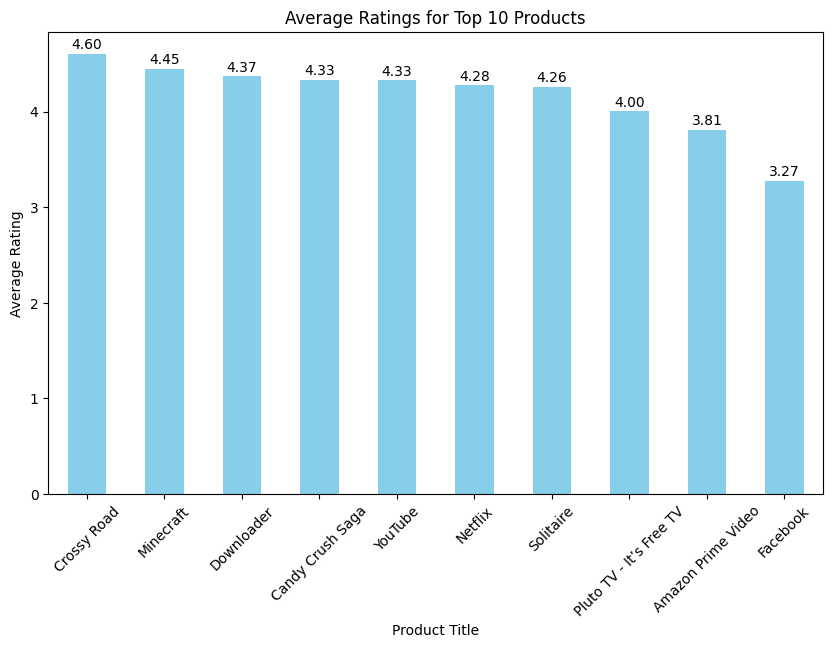

In [27]:
# Filter the DataFrame to include only the top 10 products
filtered_df = filtered_data[filtered_data['title_y'].isin(top10_products)]

# Calculate average ratings for the top 10 products
avg_ratings = filtered_df.groupby('title_y')['rating'].mean().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
bars = avg_ratings.plot(kind='bar', color='skyblue')

# Add text labels to each bar
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,   # X-coordinate (center of the bar)
        bar.get_height() + 0.02,             # Y-coordinate (height of the bar + some offset)
        f'{bar.get_height():.2f}',           # Text to display (formatted to 2 decimal places)
        ha='center',                         # Horizontal alignment
        va='bottom'                          # Vertical alignment
    )

# Titles and labels
plt.title('Average Ratings for Top 10 Products')
plt.xlabel('Product Title')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

In [28]:
# Find highest rated products
# Calculate the average rating for each product based on parent_asin
average_ratings = filtered_data.groupby('title_y')['rating'].mean()

# Retrieve the product with the highest average rating
highest_rated_product = average_ratings.idxmax()
highest_rating = average_ratings.max()

# Retrieve the product with the lowest average rating
lowest_rated_product = average_ratings.idxmin()
lowest_rating = average_ratings.min()

# Display the results
print(f"Highest Rated Product: Title = {highest_rated_product}, Average Rating = {highest_rating}")
print(f"Lowest Rated Product: Title = {lowest_rated_product}, Average Rating = {lowest_rating}")

Highest Rated Product: Title = Crossy Road, Average Rating = 4.601756899411853
Lowest Rated Product: Title = Facebook, Average Rating = 3.273202482125995


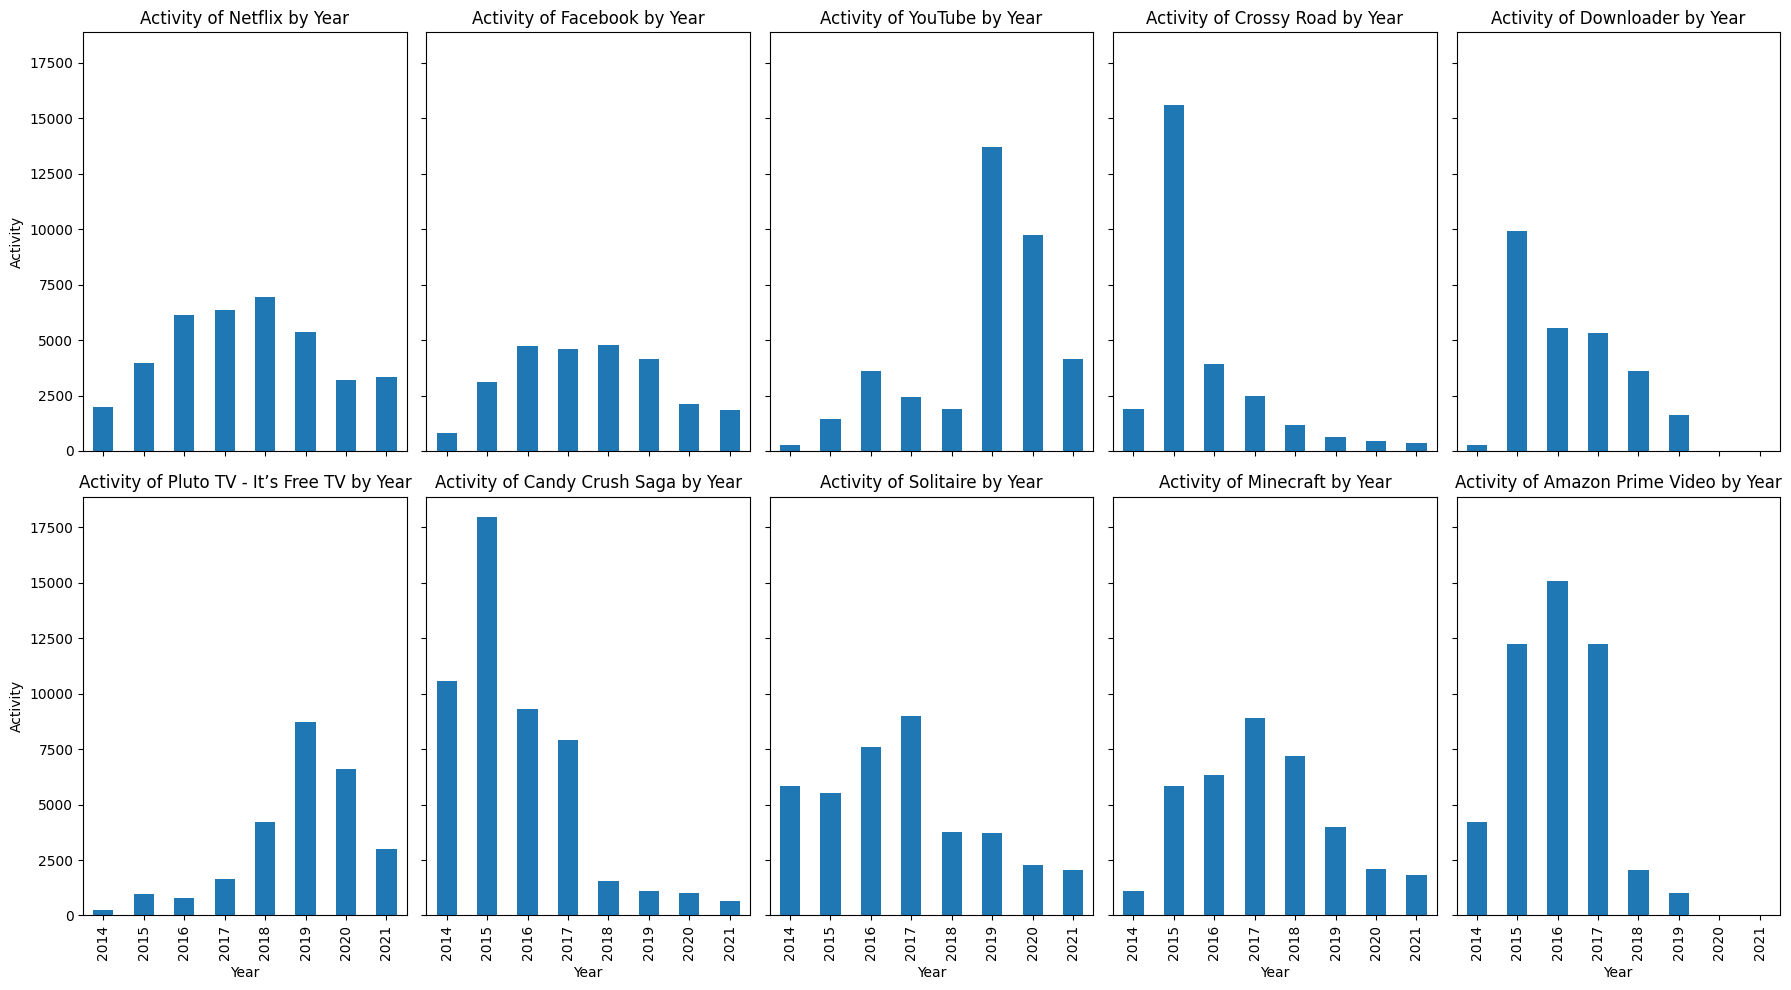

In [30]:
# Get unique products
products = filtered_data['title_y'].unique()

# Create subplots with 2 rows and 5 columns (10 products)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 10), sharey=True, sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, product in enumerate(products):
    # Filter data for the specific product
    product_data = filtered_data[filtered_data['title_y'] == product]

    # Plot the activity by year for this product
    product_data['year'].value_counts().sort_index().plot(
        kind='bar', 
        ax=axes[i], 
        title=f'Activity of {product} by Year'
    )
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Activity')

# Adjust layout and spacing
plt.tight_layout()
plt.show()

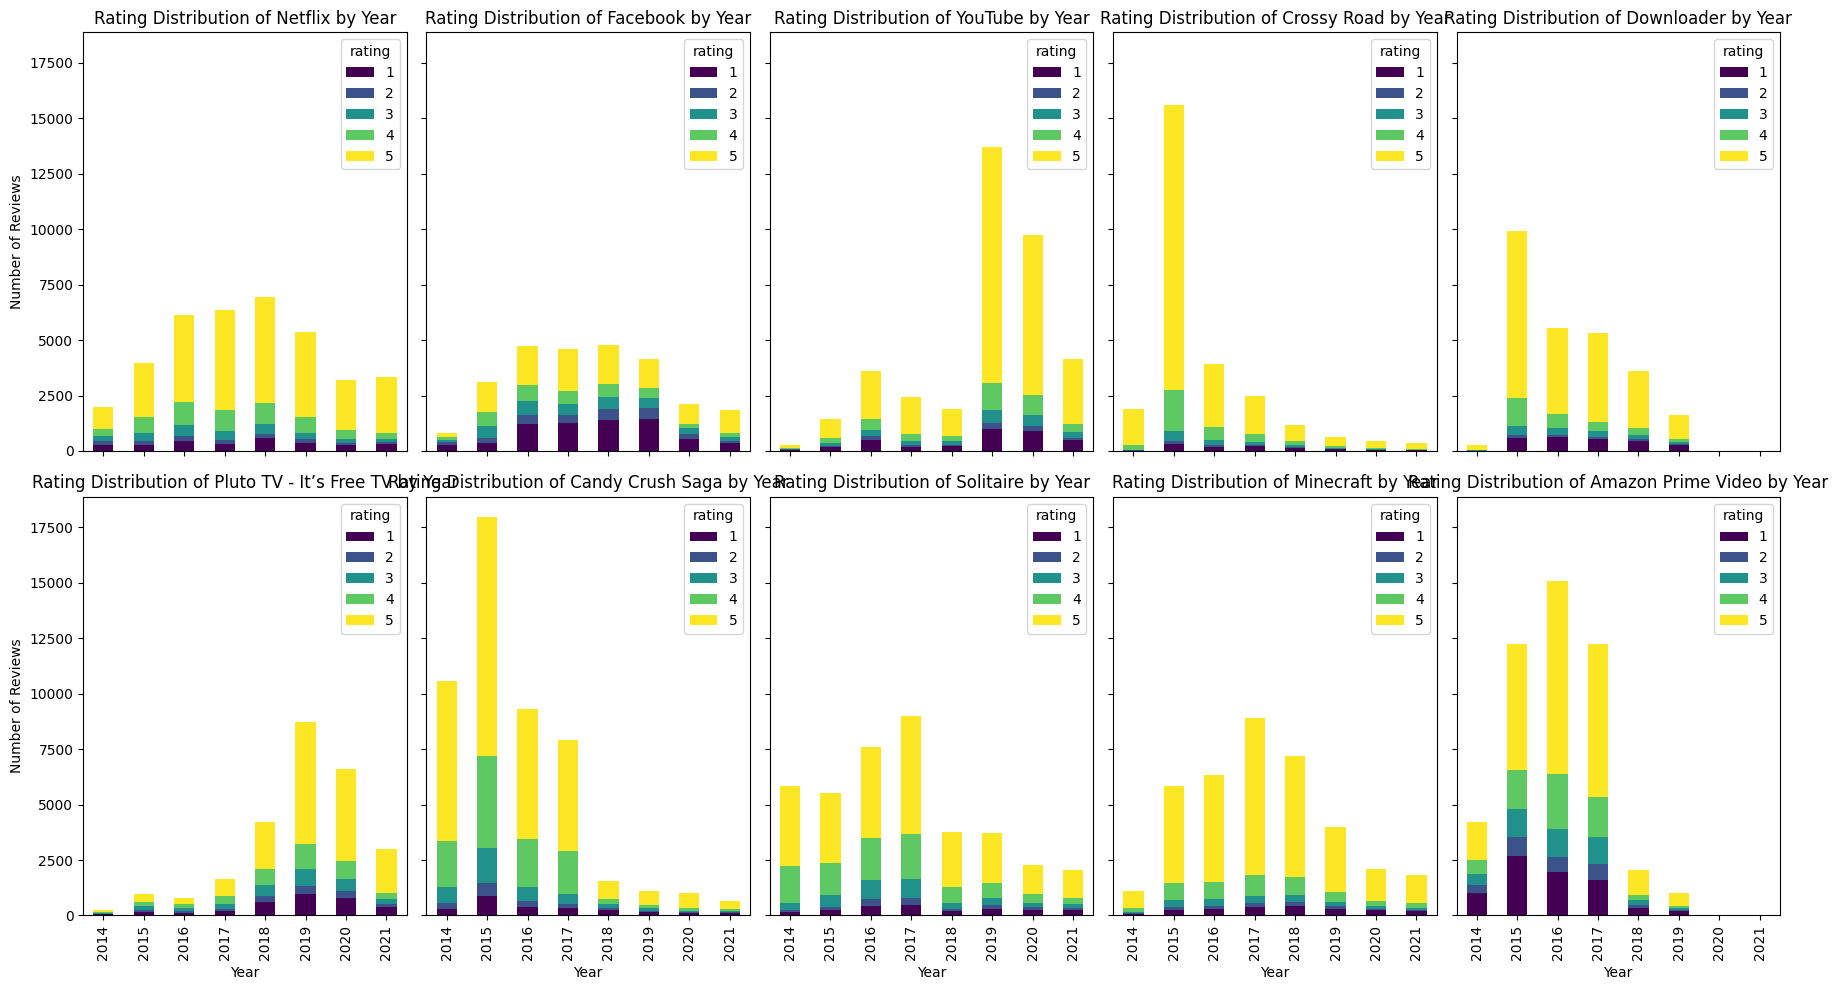

In [31]:
# Get unique products
products = filtered_data['title_y'].unique()

# Create subplots with 2 rows and 5 columns (for 10 products)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 10), sharey=True, sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, product in enumerate(products):
    # Filter data for the specific product
    product_data = filtered_data[filtered_data['title_y'] == product]

    # Create a rating distribution table: Group by 'year' and 'rating', and count occurrences
    rating_distribution = product_data.groupby(['year', 'rating']).size().unstack(fill_value=0)

    # Plot a stacked bar chart of the rating distribution
    rating_distribution.plot(
        kind='bar', 
        stacked=True, 
        ax=axes[i], 
        colormap='viridis', 
        title=f'Rating Distribution of {product} by Year'
    )
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Number of Reviews')

# Adjust layout and spacing
plt.tight_layout()
plt.show()

In [33]:
# # analyse the distributions again to ensure consistency
# plot_timestamp(sampled_df, 'year')
# plot_distribution(sampled_df, 'rating')
# plot_distribution(sampled_df, 'verified_purchase')
# plot_distribution(sampled_df, 'text_length_vs_rating')
# # Find highest rated products
# # Calculate the average rating for each product based on parent_asin
# average_ratings = sampled_df.groupby('parent_asin')['rating'].mean()

# # Retrieve the product with the highest average rating
# highest_rated_product = average_ratings.idxmax()
# highest_rating = average_ratings.max()

# # Retrieve the product with the lowest average rating
# lowest_rated_product = average_ratings.idxmin()
# lowest_rating = average_ratings.min()

# # Display the results
# print(f"Highest Rated Product: ASIN = {highest_rated_product}, Average Rating = {highest_rating}")
# print(f"Lowest Rated Product: ASIN = {lowest_rated_product}, Average Rating = {lowest_rating}")

# Sentiment Analysis

We will make use of the **TextBlob** library as well as **NLTK** for performing sentiment analysis on the reviews. Furthermore, we will classify each review according to the sentiment, highlighting whether a specific review is positive, negative, or neutral. Finally, we will present the resuls and analyse how the sentiment changed over the years.

In [45]:
df = filtered_data.copy()

class SentimentAnaliser:

    def clean_text(self, df):
        cleaned = []
        all_text = df['text']

        for index, text in enumerate(all_text):
            # Text cleaning steps
            text = text.lower()
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
            text = text.translate(str.maketrans('', '', string.punctuation))
            text = re.sub(r'\d+', '', text)
            text = re.sub(r'\s+', ' ', text).strip()
            cleaned.append(text)

            # Progress display
            if (index + 1) % 100 == 0:
                print(f'\rCompleted text cleaning for {index + 1} reviews. [{index + 1}/{df.shape[0]}] ({round((index + 1)/df.shape[0] * 100, 2)}%)', end='')

        df['cleaned_text'] = cleaned
        print('\nText cleaning complete for all reviews.')
        return df    

    def get_sentiment(self, df):
        sentiments = []
        customer_reviews = df['cleaned_text']

        for index, review in enumerate(customer_reviews):
            analysis = TextBlob(review)
            sentiment_score = analysis.sentiment.polarity
            sentiments.append(sentiment_score)

            if (index + 1) % 100 == 0:
                print(f'\rCompleted sentiment analysis for {index + 1} reviews. [{index + 1}/{df.shape[0]}] ({round((index + 1)/df.shape[0] * 100, 2)}%)', end='')

        df['sentiment'] = sentiments
        print('\nSentiment analysis complete for all reviews.')
        return df

    def classify_sentiment(self, df):
        sentiments_classified = []

        for index, score in enumerate(df['sentiment']):
            if score > 0:
                sentiments_classified.append('positive')
            elif score < 0:
                sentiments_classified.append('negative')
            else:
                sentiments_classified.append('neutral')

            if (index + 1) % 100 == 0:
                print(f'\rClassified sentiment for {index + 1} reviews. [{index + 1}/{df.shape[0]}] ({round((index + 1)/df.shape[0] * 100, 2)}%)', end='')

        df['sentiment_label'] = sentiments_classified
        print('\nSentiment classification complete for all reviews.')
        return df

    # Updated: Perform sentiment analysis for all products side-by-side
    def perform_sentiment(self, df):        
        # clean text
        df = self.clean_text(df)

        # Apply sentiment analysis and classification to the dataframe
        df = self.get_sentiment(df)
        df = self.classify_sentiment(df)
        return df
    
    def plot_sentiment(self, df):
        products = df['title_y'].unique()
        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 10), sharey=True, sharex=True)
        axes = axes.flatten()

        for i, product in enumerate(products):
            product_data = df[df['title_y'] == product]
            sentiment_counts = product_data['sentiment_label'].value_counts()

            sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=axes[i])
            axes[i].set_title(f'Sentiment Distribution of {product}')
            axes[i].set_xlabel('Sentiment')
            axes[i].set_ylabel('Number of Reviews')

        plt.tight_layout()
        plt.show()

    # Updated: Plot rating (sentiment label) distribution over the years for each product
    def plot_rating_vs_year(self, df):
        products = df['title_y'].unique()
        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 10), sharey=True, sharex=True)
        axes = axes.flatten()

        for i, product in enumerate(products):
            product_data = df[df['title_y'] == product]
            rating_distribution = product_data.groupby(['year', 'sentiment_label']).size().unstack(fill_value=0)

            rating_distribution.plot(kind='bar', stacked=True, ax=axes[i], colormap='viridis')
            axes[i].set_title(f'{product}: Sentiment vs Year')
            axes[i].set_xlabel('Year')
            axes[i].set_ylabel('Number of Reviews')

        plt.tight_layout()
        plt.show()

    # Updated: Plot sentiment vs verification for each product
    def plot_sentiment_vs_verification(self, df):
        products = df['title_y'].unique()
        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 10), sharey=True, sharex=True)
        axes = axes.flatten()

        for i, product in enumerate(products):
            product_data = df[df['title_y'] == product]
            verified = product_data[product_data['verified_purchase'] == True]
            non_verified = product_data[product_data['verified_purchase'] == False]

            verified_sentiment_counts = verified['sentiment_label'].value_counts(normalize=True)
            non_verified_sentiment_counts = non_verified['sentiment_label'].value_counts(normalize=True)

            comparison_df = pd.DataFrame({
                'Verified': verified_sentiment_counts,
                'Non-Verified': non_verified_sentiment_counts
            }).fillna(0)

            comparison_df.plot(kind='bar', stacked=True, ax=axes[i])
            axes[i].set_title(f'{product}: Sentiment vs Verification')
            axes[i].set_xlabel('Sentiment')
            axes[i].set_ylabel('Proportion')

        plt.tight_layout()
        plt.show()
        
    def plot_sentiment_over_time(self, df):
        # Count the number of reviews for each product-year combination
        counts = df.groupby(['title_y', 'year']).size().reset_index(name='counts')

        # Find the minimum count of reviews across all product-year combinations
        min_count = counts['counts'].min()

        balanced_samples = []

        # Loop through each product-year combination and sample reviews
        for (product, year), group in df.groupby(['title_y', 'year']):
            if len(group) > min_count:
                # Sample reviews if the group has more than the minimum count
                sampled_reviews = group.sample(n=min_count, random_state=1)
            else:
                # Use all available reviews if they are less than or equal to the minimum count
                sampled_reviews = group

            balanced_samples.append(sampled_reviews)

        # Concatenate all the sampled reviews into a single DataFrame
        balanced_df = pd.concat(balanced_samples).reset_index(drop=True)

        # Create a figure and axes for plotting with 2 rows and 5 columns
        n_products = len(balanced_df['title_y'].unique())
        n_rows = 2
        n_cols = 5
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharey=True, sharex=True)
        axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

        # Loop through each product to plot sentiment trends
        for i, product in enumerate(balanced_df['title_y'].unique()):
            # Filter the dataframe for the current product
            product_df = balanced_df[balanced_df['title_y'] == product]

            # Calculate the average sentiment by year for the current product
            sentiment_by_year = product_df.groupby('year')['sentiment'].mean().reset_index()

            # Plot the sentiment trend for this product on the corresponding axis
            sns.lineplot(x='year', y='sentiment', data=sentiment_by_year, marker='o', ax=axes[i])

            # Add title and labels to each subplot
            axes[i].set_title(product)
            axes[i].set_xlabel('Year')
            axes[i].set_ylabel('Average Sentiment Polarity')

        # Adjust layout for better spacing
        plt.tight_layout()

        # Display the plot
        plt.show()
        
# perform sentiment analysis on sampled data
SA_sampled = SentimentAnaliser()
df = SA_sampled.perform_sentiment(df)

Completed text cleaning for 367800 reviews. [367800/367808] (100.0%)
Text cleaning complete for all reviews.
Completed sentiment analysis for 367800 reviews. [367800/367808] (100.0%)
Sentiment analysis complete for all reviews.
Classified sentiment for 367800 reviews. [367800/367808] (100.0%)
Sentiment classification complete for all reviews.


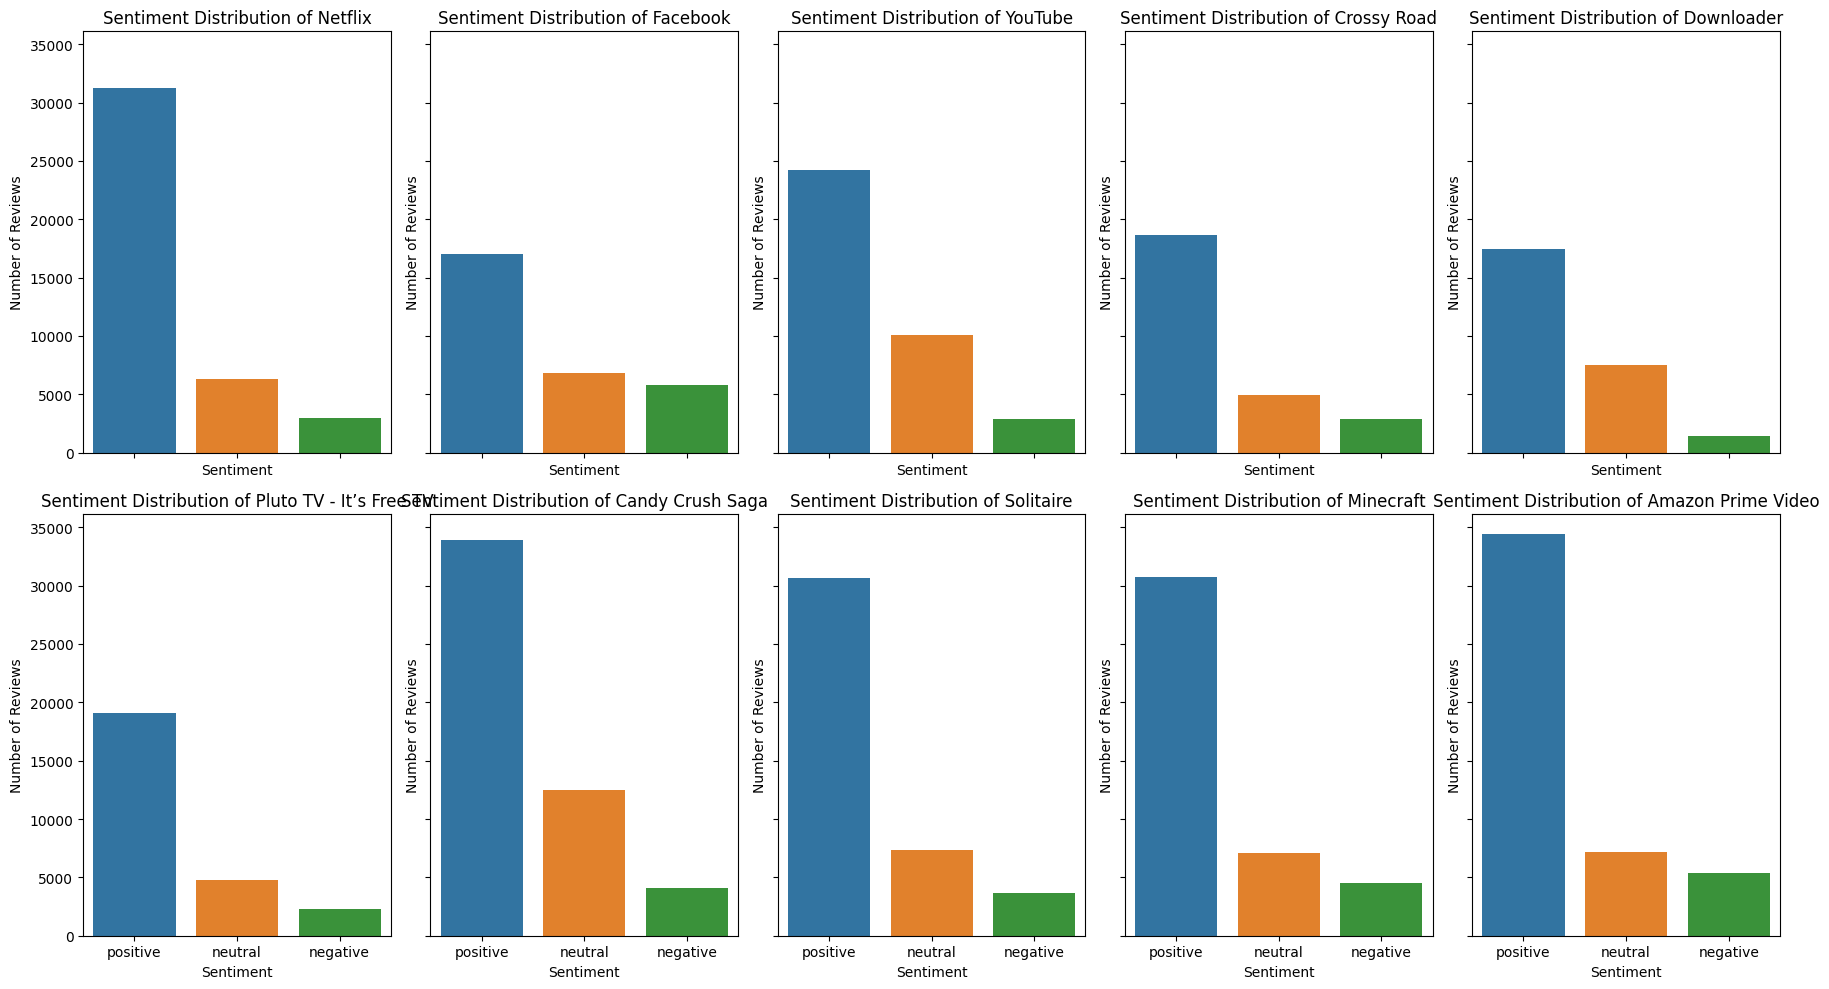

In [46]:
SA_sampled.plot_sentiment(df)

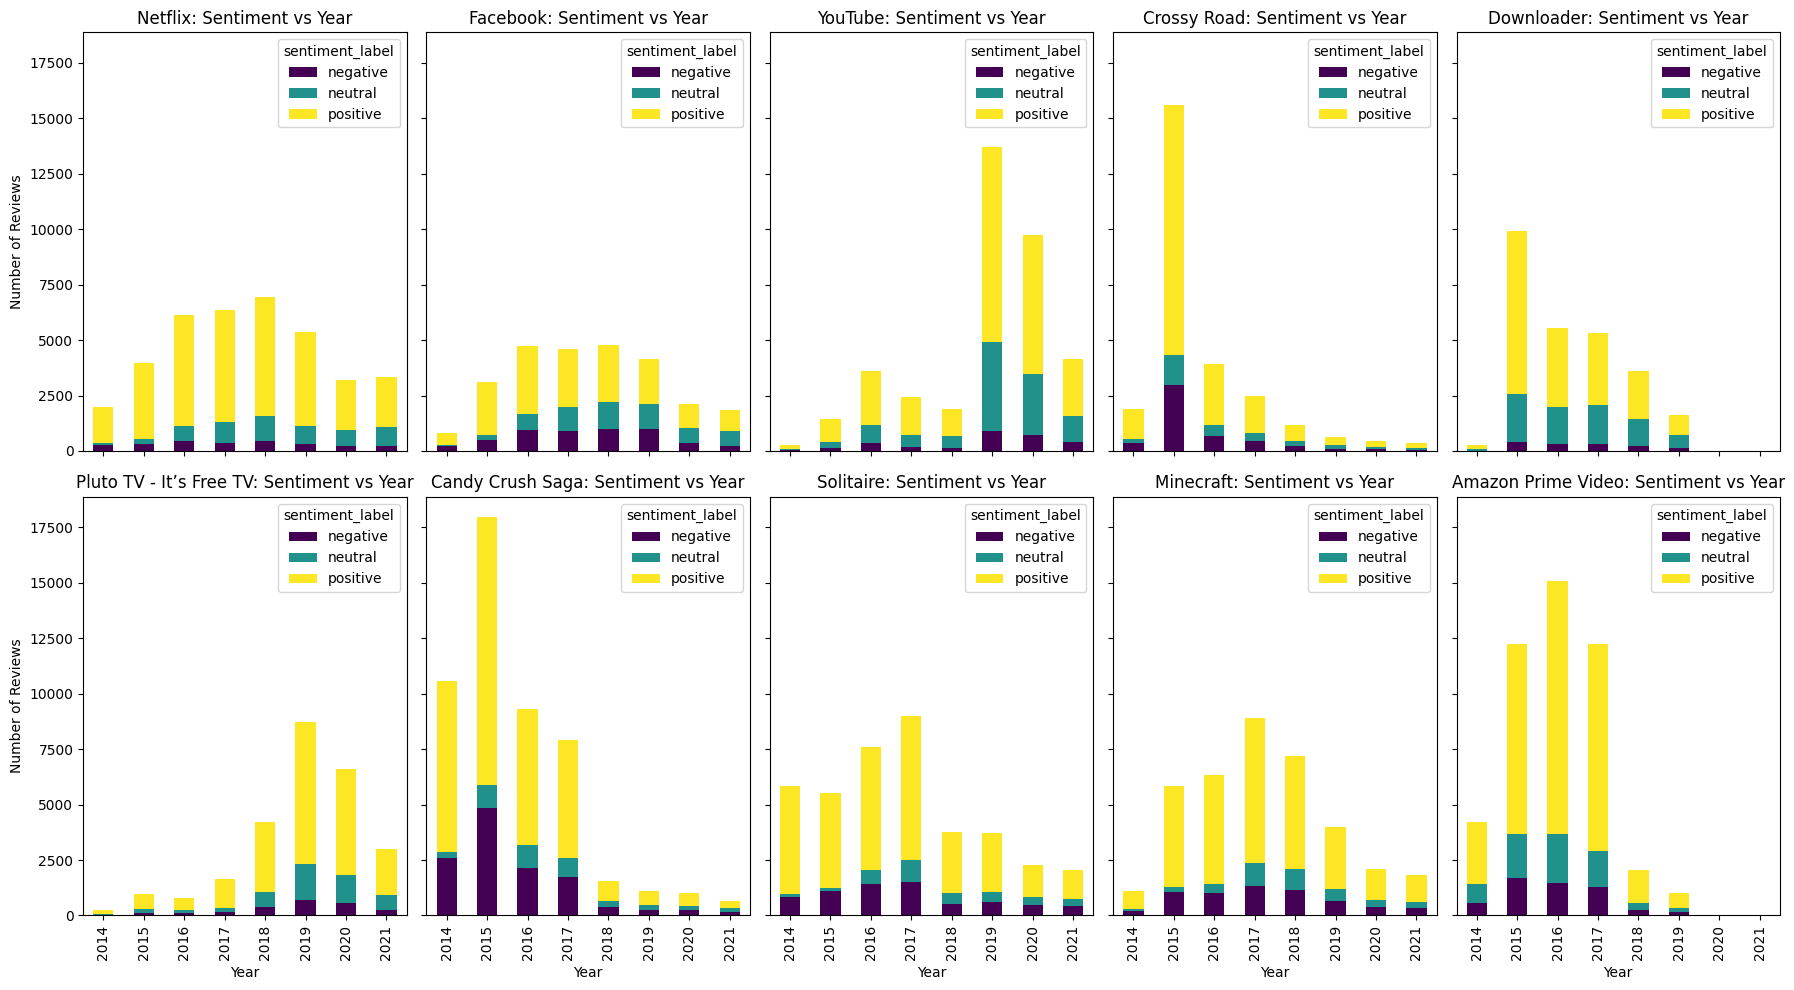

In [47]:
SA_sampled.plot_rating_vs_year(df)

From the above illustrations we observe that the majority of products show more positive sentiment over the years. Some products such as *Candy Crush Saga* shows a spike in number of reviews made which could indicate that the developers made some impactful updates. This could suggest that previous years have received excellent makreting campaigns and product updates. However, there was a significant drop in reviews for the later years which could indicate that users were satisfied with the current state of the application and did not need to make reviews. But is could also indicate that users stopped using the application, creating a negative impact on the company who developed it. Therefore, developers need to focus on implementing features that closely alligns with the users' needs and should listen more closely to their feedback.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

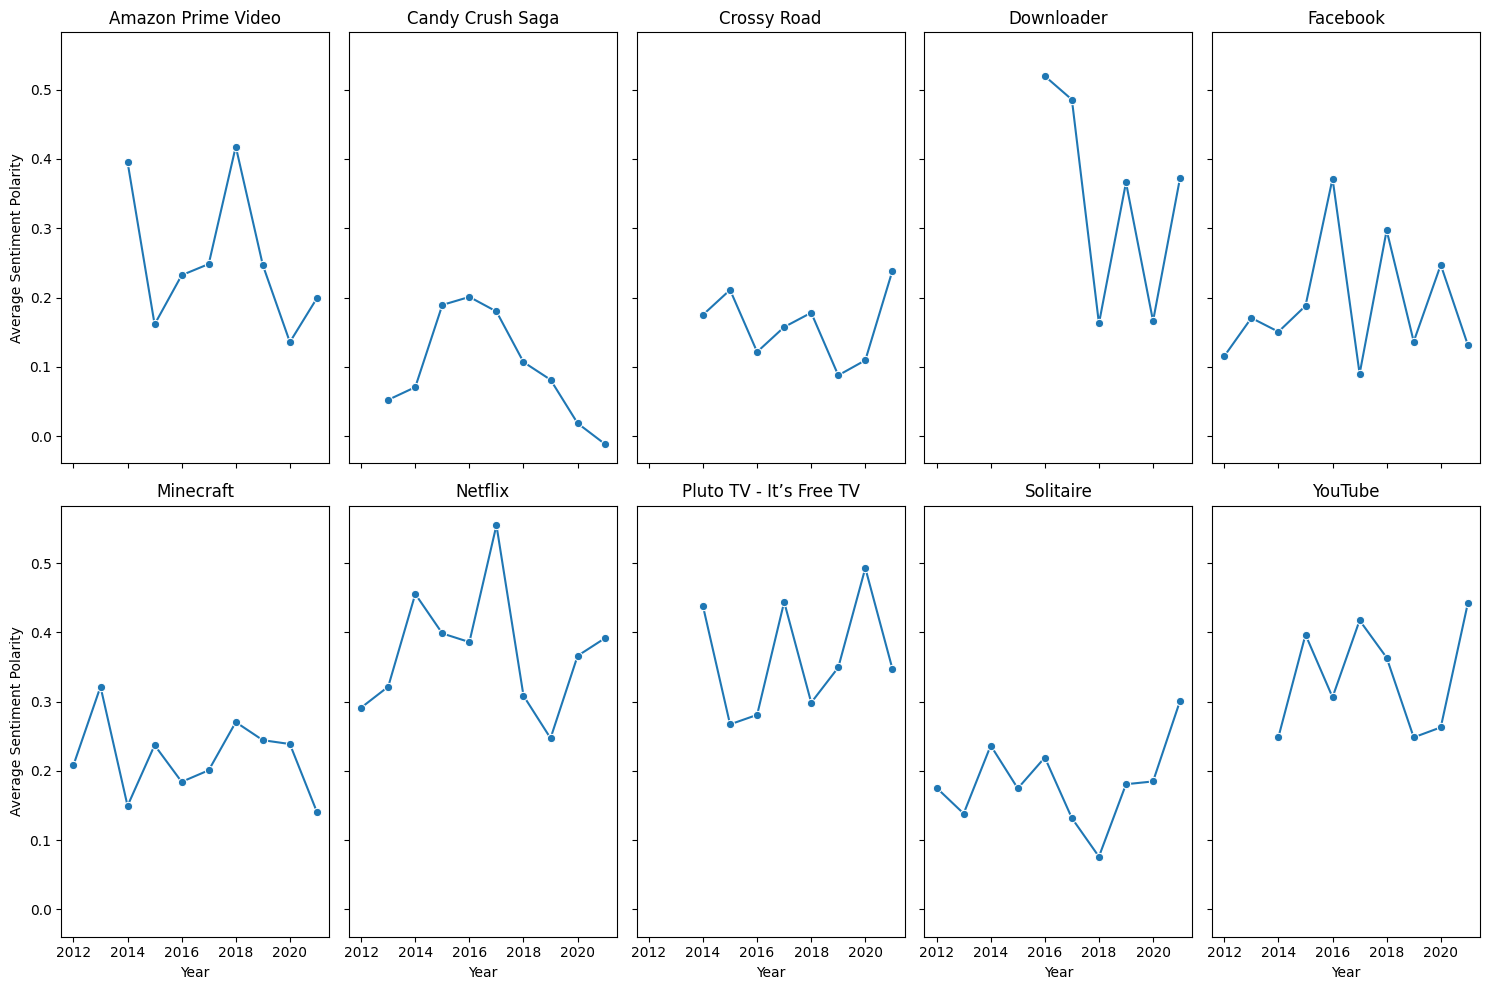

In [49]:
SA_sampled.plot_sentiment_over_time(df)

We analyse that the majority of reviews a considered positive. This is supported by the range of polarity scores over the years which ranges from 0 to 0.5 which is considered an overall positive sentiment over the years.

### Insights:
**Positive Sentiment Trend:**
- *Amazon Prime Video*: Maintains a consistently positive sentiment throughout the entire period, suggesting strong customer satisfaction.
- *Minecraft*: Exhibits a generally positive sentiment, with a slight dip around 2016 but recovering thereafter.
- *Netflix*: Shows a steady positive sentiment, with a slight peak in 2018.
- *Pluto TV - It's Free TV*: Maintains a positive sentiment, with a slight dip around 2014 but recovering quickly.

*Mixed Sentiment Trend:**
- *Candy Crush Saga*: Shows a mixed trend, with positive sentiment in the early years but declining towards 2020.
- *Crossy Road*: Exhibits a similar pattern to Candy Crush Saga, with an initial positive sentiment followed by a decline.
- *Downloader*: Experiences fluctuating sentiment, with periods of positive and negative sentiment.
- *Facebook*: Shows a mixed trend, with positive sentiment in some years and negative sentiment in others.
- *Solitaire*: Exhibits a generally negative sentiment, with a slight improvement in 2018 but declining again towards 2020.
- *YouTube*: Experiences fluctuating sentiment, with periods of positive and negative sentiment.

Overall, the products showed positive sentiment on average. However, some products show fluctuating trends which could mean that the updates of the products are not consistent in terms of quality and the impact it makes. Furthermore, the decline in sentiment might suggest that developers of the products need to consider adding new features and changes to the application such that they keep customers engaged.


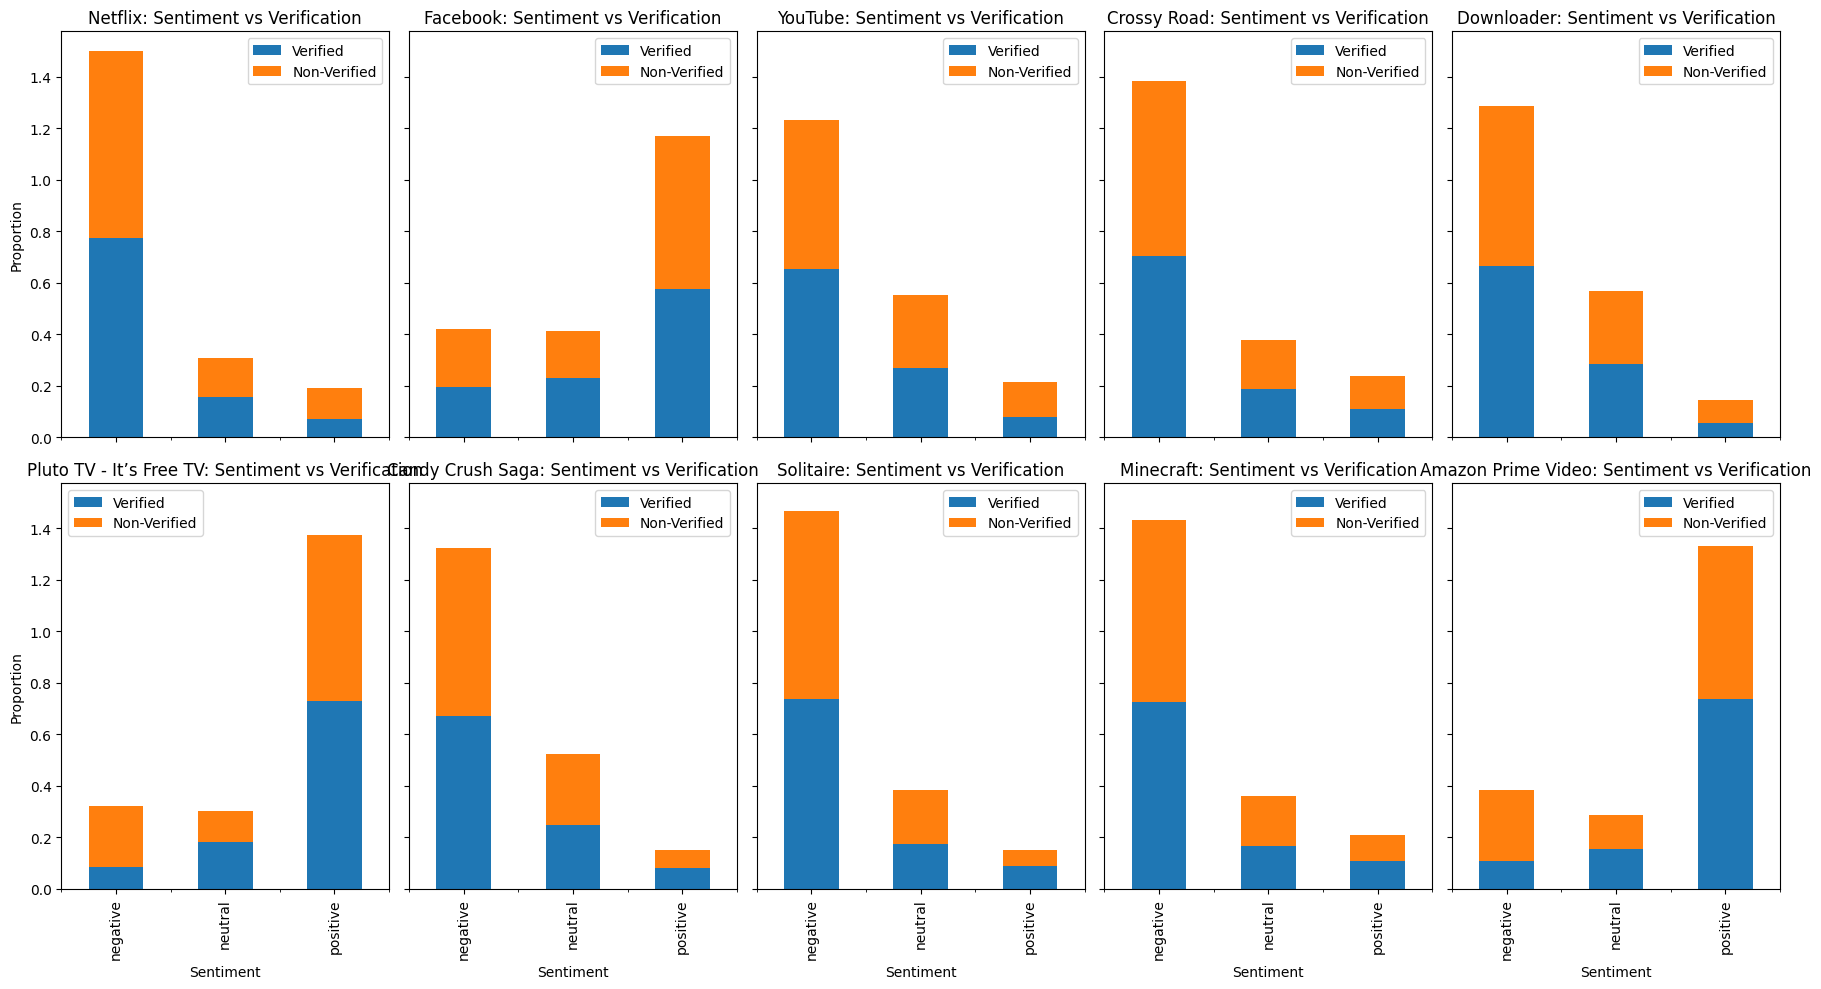

In [48]:
SA_sampled.plot_sentiment_vs_verification(df)

Overall, the maojirty of the products show a balance between the verified and non-verified purchases for each sentiment category. This indicates that the sentiment in reviews towards the products are not affected by the fact that a purchase was verified or not.